# **Dog & Cat classification**

In [1]:
import os
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, LeakyReLU, BatchNormalization

In [2]:
print("Is GPU available: ", tf.test.is_gpu_available())

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Check TensorFlow version
print("TensorFlow GPU version:", tf.__version__)

# Check if TensorFlow is using GPU
print("TensorFlow is using GPU:", tf.test.is_built_with_cuda())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available:  True
Num GPUs Available:  1
TensorFlow GPU version: 2.10.0
TensorFlow is using GPU: True


In [3]:
%%time
import cv2
import os

TB_LOGS = "tensorboard_logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
IMAGE_SIZE = (256, 256)
des = 'C:/Users/Vu Tuan Minh/Desktop/VA/AI/oxford-images/'
BASE_PATH = 'C:/Users/Vu Tuan Minh/Desktop/VA/AI/oxford-images/'
imageData = []
filenames = os.listdir(des)

for name in tqdm(filenames, desc = 'Loading image data', unit = ' images'):
    img = load_img(os.path.join(BASE_PATH, name))
    img = tf.image.resize_with_pad(img_to_array(img, dtype = 'uint8'), *IMAGE_SIZE).numpy().astype('uint8')
    imageData.append(img)

labels =  [' '.join(name.split('_')[:-1]) for name in filenames]
resized_images = [cv2.resize(image, IMAGE_SIZE) for image in imageData]
imageData = np.array(resized_images)

print("Image data shape:", imageData.shape)
print("Image label shape: ", len(labels))

Loading image data: 100%|██████████| 7388/7388 [01:16<00:00, 96.57 images/s] 


Image data shape: (7388, 256, 256, 3)
Image label shape:  7388
CPU times: total: 1min 17s
Wall time: 1min 17s


In [4]:
labelEncDict = {name : ind for ind, name in enumerate(np.unique(labels))}
print(len(labelEncDict))
for k, v in labelEncDict.items():
    print(f"{k:32} : {v}")

37
Abyssinian                       : 0
Bengal                           : 1
Birman                           : 2
Bombay                           : 3
British Shorthair                : 4
Egyptian Mau                     : 5
Maine Coon                       : 6
Persian                          : 7
Ragdoll                          : 8
Russian Blue                     : 9
Siamese                          : 10
Sphynx                           : 11
american bulldog                 : 12
american pit bull terrier        : 13
basset hound                     : 14
beagle                           : 15
boxer                            : 16
chihuahua                        : 17
english cocker spaniel           : 18
english setter                   : 19
german shorthaired               : 20
great pyrenees                   : 21
havanese                         : 22
japanese chin                    : 23
keeshond                         : 24
leonberger                       : 25
miniature pinscher 

In [5]:
labelDecDict = {ind: name for name, ind in labelEncDict.items()}
print(len(labelDecDict))
for k, v in labelDecDict.items():
    print(f"{k:3} : {v}")

37
  0 : Abyssinian
  1 : Bengal
  2 : Birman
  3 : Bombay
  4 : British Shorthair
  5 : Egyptian Mau
  6 : Maine Coon
  7 : Persian
  8 : Ragdoll
  9 : Russian Blue
 10 : Siamese
 11 : Sphynx
 12 : american bulldog
 13 : american pit bull terrier
 14 : basset hound
 15 : beagle
 16 : boxer
 17 : chihuahua
 18 : english cocker spaniel
 19 : english setter
 20 : german shorthaired
 21 : great pyrenees
 22 : havanese
 23 : japanese chin
 24 : keeshond
 25 : leonberger
 26 : miniature pinscher
 27 : newfoundland
 28 : pomeranian
 29 : pug
 30 : saint bernard
 31 : samoyed
 32 : scottish terrier
 33 : shiba inu
 34 : staffordshire bull terrier
 35 : wheaten terrier
 36 : yorkshire terrier


In [26]:
# Count number of images of each label
for i in labelEncDict.keys():
    print(f"{i:3} : {labels.count(i)}")

Abyssinian : 199
Bengal : 200
Birman : 200
Bombay : 200
British Shorthair : 200
Egyptian Mau : 200
Maine Coon : 200
Persian : 199
Ragdoll : 200
Russian Blue : 200
Siamese : 200
Sphynx : 200
american bulldog : 200
american pit bull terrier : 200
basset hound : 200
beagle : 200
boxer : 200
chihuahua : 200
english cocker spaniel : 200
english setter : 200
german shorthaired : 200
great pyrenees : 200
havanese : 200
japanese chin : 200
keeshond : 200
leonberger : 200
miniature pinscher : 200
newfoundland : 200
pomeranian : 200
pug : 200
saint bernard : 200
samoyed : 200
scottish terrier : 199
shiba inu : 200
staffordshire bull terrier : 191
wheaten terrier : 200
yorkshire terrier : 200


Load image data into a numpy array

Since images are of different aspect ratios, images are loaded with padding to avoid distortion.

In [6]:
RANDOM_STATE = 7
TRAIN_SIZE, VAL_SIZE, TEST_SIZE = 0.8, 0.1, 0.1

BATCH_SIZE = 32
EPOCHS = 200
LEARNING_RATE = 0.0001
PLOTS_DPI = 200

Encoding Target labels

In [7]:
labelsEncoded = list(map(lambda x : labelEncDict.get(x), labels))
print(len(labelsEncoded))

for i, l in zip(filenames[::1000], labelsEncoded[::1000]):
    print(f"{i:32}\t{labelDecDict[l]:32}\t{l}")

7388
Abyssinian_1.jpg                	Abyssinian                      	0
Bengal_10.jpg                   	Bengal                          	1
chihuahua_10.jpg                	chihuahua                       	17
great_pyrenees_10.jpg           	great pyrenees                  	21
Maine_Coon_10.jpg               	Maine Coon                      	6
pug_100.jpg                     	pug                             	29
scottish_terrier_100.jpg        	scottish terrier                	32
wheaten_terrier_11.jpg          	wheaten terrier                 	35


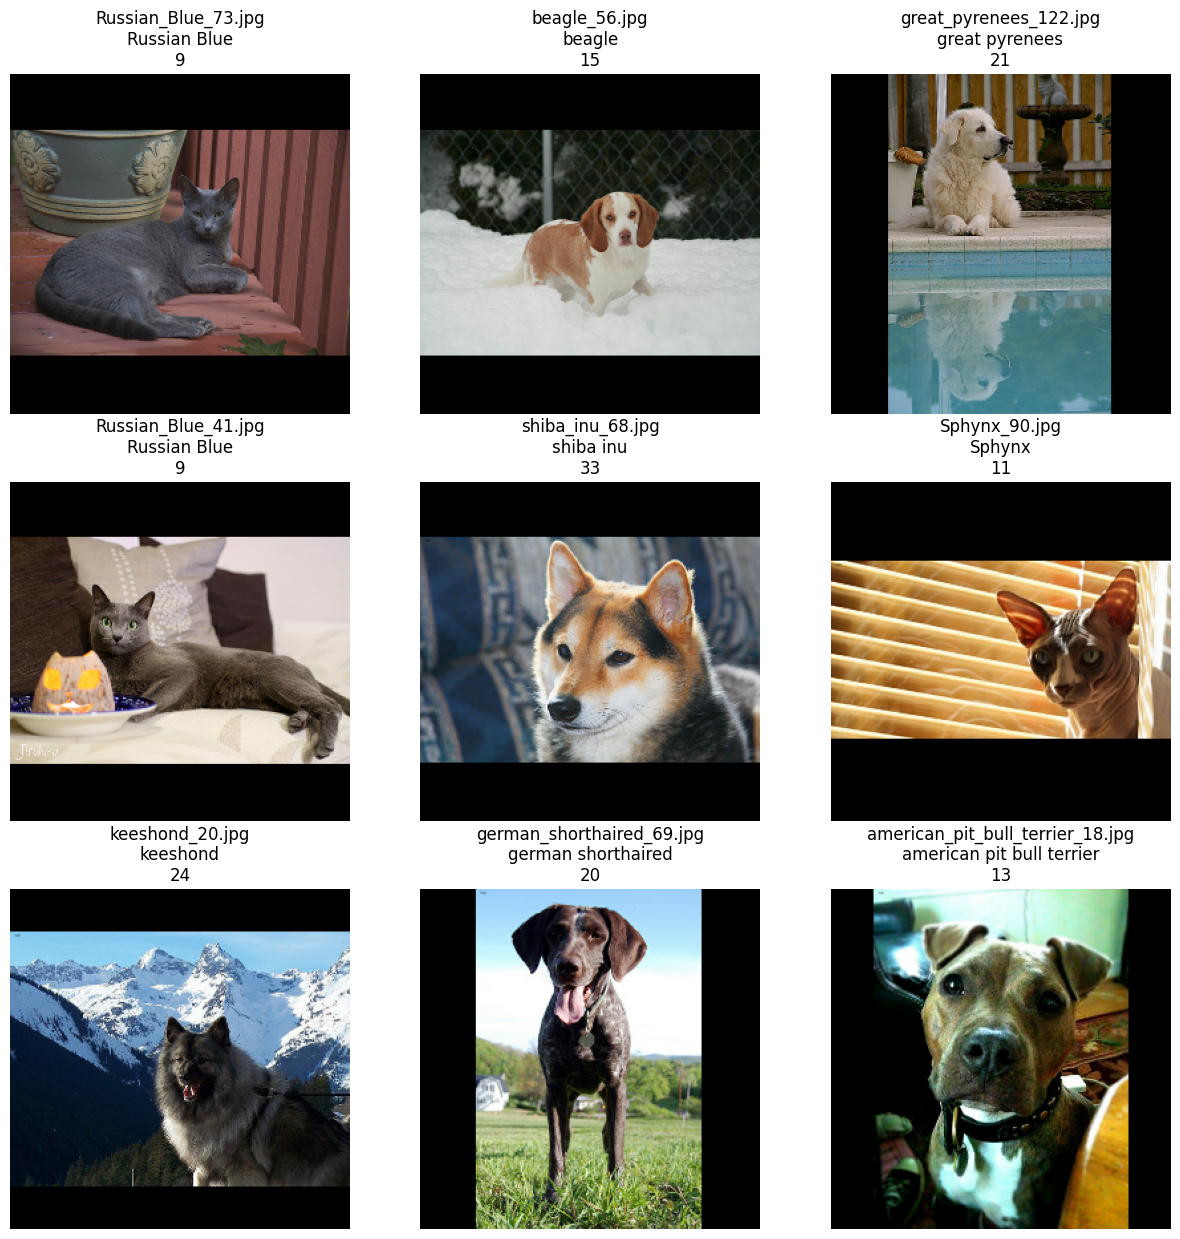

In [19]:
plt.subplots(nrows = 3, ncols = 3, figsize = (15, 15))

for i, imgIndex in enumerate(np.random.randint(0, len(filenames), size = 9)):
  plt.subplot(3, 3, i + 1)
  plt.axis(False)
  plt.grid(False)
  plt.title(f'{filenames[imgIndex]}\n{labels[imgIndex]}\n{labelsEncoded[imgIndex]}')
  plt.imshow(imageData[imgIndex])
plt.show()

Train, Validation and Test data preparation

Split data and labels into 3 sets

In [ ]:
imageData.max()

255

In [8]:
X_tv, X_test, y_tv, y_test = train_test_split(
    imageData,
    labelsEncoded,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = labelsEncoded
    )

X_train, X_val, y_train, y_val = train_test_split(
    X_tv,
    y_tv,
    test_size = VAL_SIZE,
    random_state = RANDOM_STATE,
    stratify = y_tv
    )

print(f'Training Data: {X_train.shape}')
print(f'Training Labels: {len(y_train)}')
print(f'\nValidation Data: {X_val.shape}')
print(f'Validation Labels: {len(y_val)}')
print(f'\nTesting Data: {X_test.shape}')
print(f'Testing Labels: {len(y_test)}')

Training Data: (5984, 256, 256, 3)
Training Labels: 5984

Validation Data: (665, 256, 256, 3)
Validation Labels: 665

Testing Data: (739, 256, 256, 3)
Testing Labels: 739


In [9]:
# Image Data Generator for training data using Image augmentation
BATCH_SIZE = 32

train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest')
train_data = train_gen.flow(x = X_train, y = y_train, batch_size = BATCH_SIZE, shuffle = True)
len(train_data)

187

In [10]:
# Image Data Generator for validation data
val_gen = ImageDataGenerator(rescale = 1./255)
val_data = val_gen.flow(x = X_val, y = y_val, batch_size = BATCH_SIZE, shuffle = True)
len(val_data)

21

In [11]:
# Image Data Generator for testing data
test_gen = ImageDataGenerator(rescale = 1./255)
test_data = test_gen.flow(x = X_test, y = y_test, batch_size = BATCH_SIZE)
len(test_data)

24

In [13]:
# Sample images from generators
# Plotting function
def plot_generator_images(gen, suptitle, labelDecDict, print_pred = False, model = None, nrows = 3, ncols = 3, figsize = (12, 12)):
    gen_data = gen.next()

    plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    plt.suptitle(suptitle, fontsize = 20)
    plt.tight_layout(rect = [0, 0, 1, 0.96], h_pad = 2)

    if(print_pred and model):
        pred = np.argmax(model.predict(gen_data[0]), axis=1)

    for i in range(nrows * ncols):
        plt.subplot(nrows, ncols, i + 1)
        plt.axis(False)
        plt.grid(False)

        if(print_pred and pred.any()):
            plt.title(f"True: {labelDecDict[gen_data[1][i]]}\nPredicted: {labelDecDict[pred[i]]}")
        else:
            plt.title(labelDecDict[gen_data[1][i]])
        plt.imshow(gen_data[0][i])

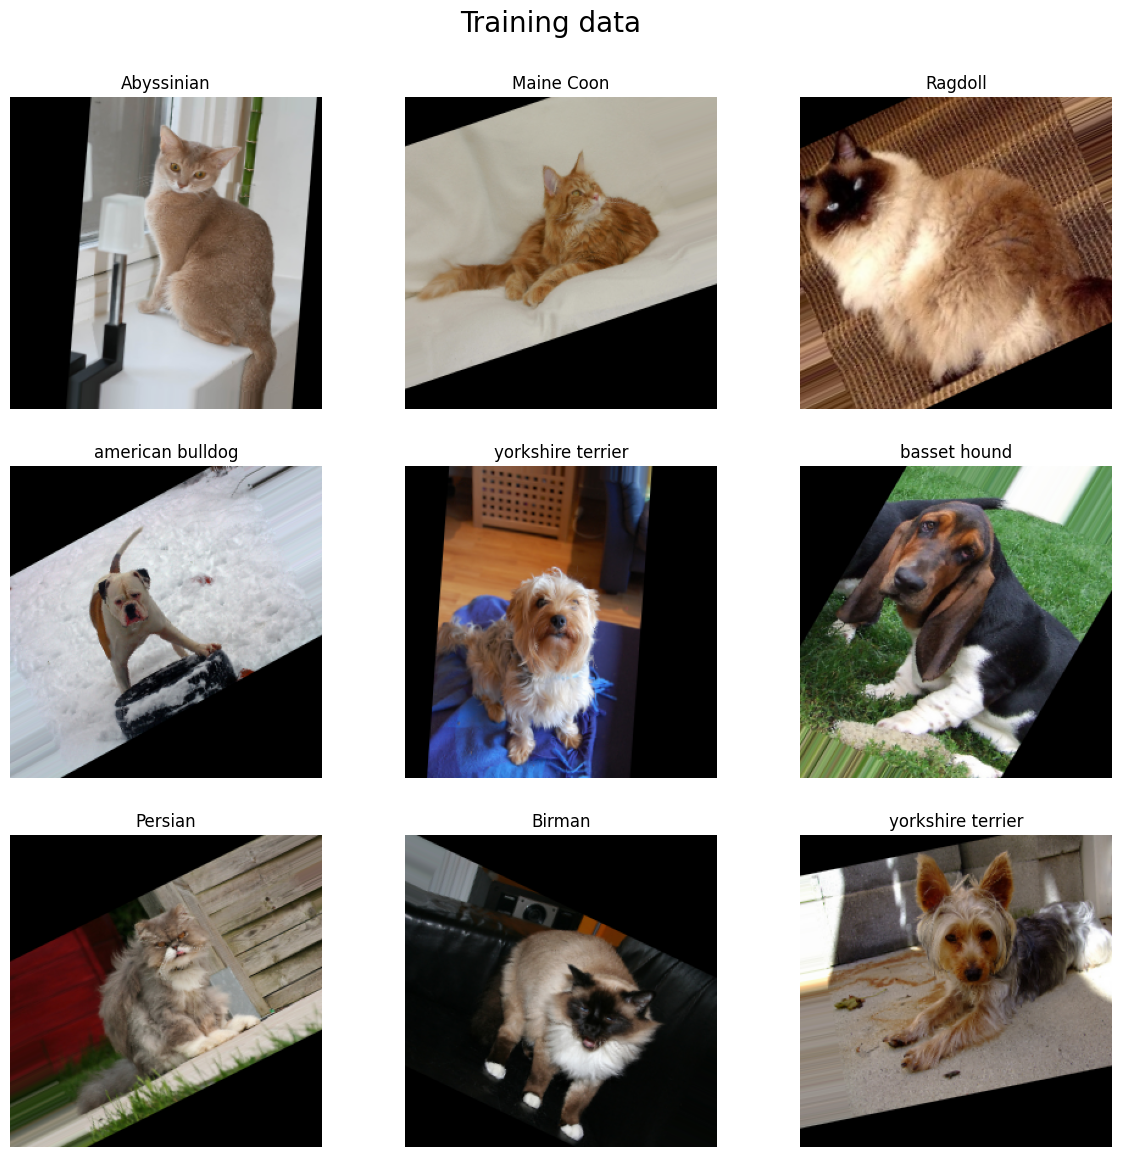

In [30]:
# Training samples
plot_generator_images(train_data, "Training data", labelDecDict)

In [ ]:
# Validation samples
plot_generator_images(val_data, "Validation data", labelDecDict)

# Model creation

## MODEL 1: CNN

In [14]:
model = Sequential([
    Conv2D(32, 5, padding = 'same', input_shape = (*IMAGE_SIZE, 3)),
    Conv2D(32, 5, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    Conv2D(32, 4, padding = 'same'),
    Conv2D(32, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),

    Conv2D(64, 4, padding = 'same'),
    Conv2D(64, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(64, 3, padding = 'same'),
    Conv2D(64, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),

    Conv2D(128, 3, padding = 'same'),
    Conv2D(128, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    Conv2D(128, 2, padding = 'same'),
    Conv2D(128, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),

    Conv2D(256, 2, padding = 'same'),
    Conv2D(256, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    
    Flatten(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512, activation = 'sigmoid'),
    Dropout(0.2),
    Dense(256, activation = 'sigmoid'),
    Dropout(0.1),
    Dense(len(labelEncDict), activation = 'softmax')
])

model.compile(optimizer = Adam(LEARNING_RATE), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['sparse_categorical_accuracy'])
 
model.fit(train_data, validation_data = val_data, epochs = 200, verbose = 1)

Epoch 1/200
187/187 [==============================] - 61s 265ms/step - loss: 3.6016 - sparse_categorical_accuracy: 0.0413 - val_loss: 3.6237 - val_sparse_categorical_accuracy: 0.0271
Epoch 2/200
187/187 [==============================] - 47s 252ms/step - loss: 3.4669 - sparse_categorical_accuracy: 0.0729 - val_loss: 3.5835 - val_sparse_categorical_accuracy: 0.0376
Epoch 3/200
187/187 [==============================] - 47s 253ms/step - loss: 3.3530 - sparse_categorical_accuracy: 0.0958 - val_loss: 3.3557 - val_sparse_categorical_accuracy: 0.1083
Epoch 4/200
187/187 [==============================] - 48s 254ms/step - loss: 3.2698 - sparse_categorical_accuracy: 0.1125 - val_loss: 3.2103 - val_sparse_categorical_accuracy: 0.1459
Epoch 5/200
187/187 [==============================] - 49s 260ms/step - loss: 3.1803 - sparse_categorical_accuracy: 0.1345 - val_loss: 3.1556 - val_sparse_categorical_accuracy: 0.1459
Epoch 6/200
187/187 [==============================] - 47s 253ms/step - loss: 3.

In [16]:
# Save the model
model.save('Oxford-pet-CNN.hdf5')

In [35]:
# !pip install shap lime 
import shap
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

def f(x):
    '''function to instantiate model output'''
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)

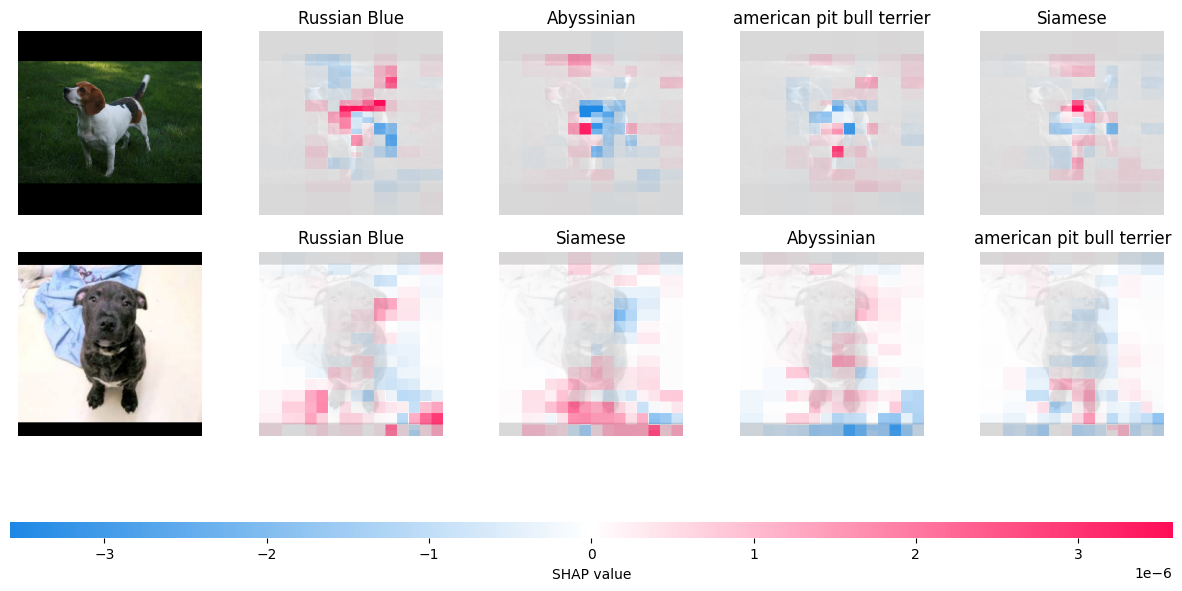

In [25]:
masker_blur = shap.maskers.Image("blur(128,128)", X_train[0].shape)
explainer_blur = shap.Explainer(f, masker_blur, output_names=list(labelDecDict.values()))
shap_values_fine = explainer_blur(X_train[0:2], max_evals=10000, batch_size=10, outputs=shap.Explanation.argsort.flip[:4])
shap.image_plot(shap_values_fine)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


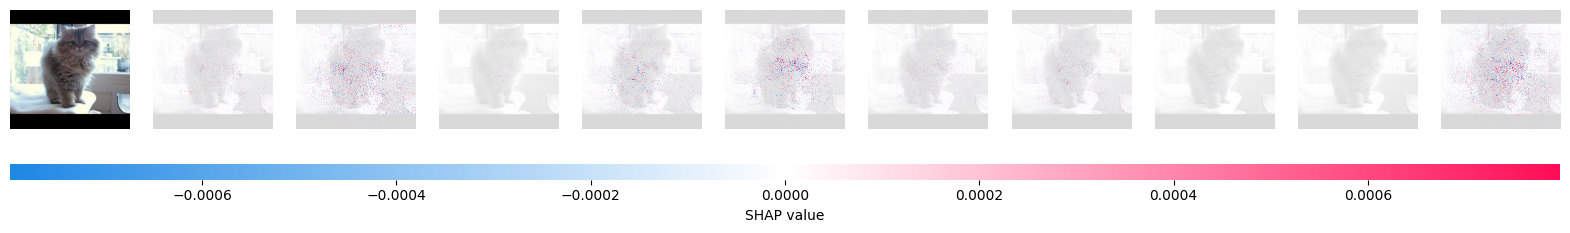

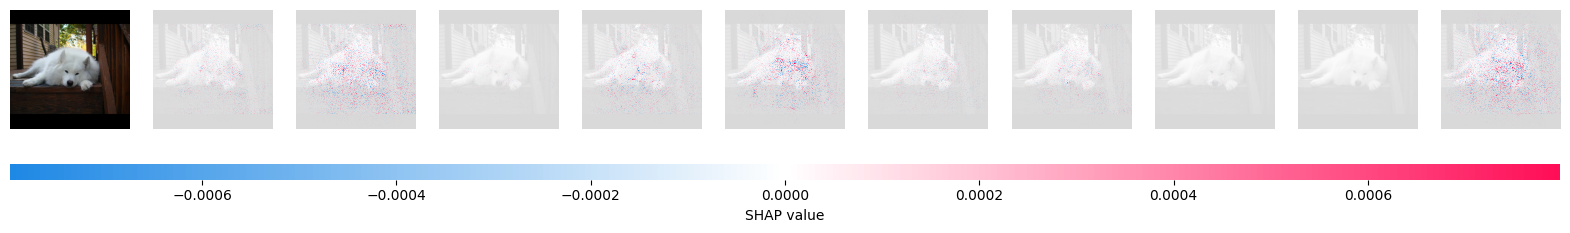

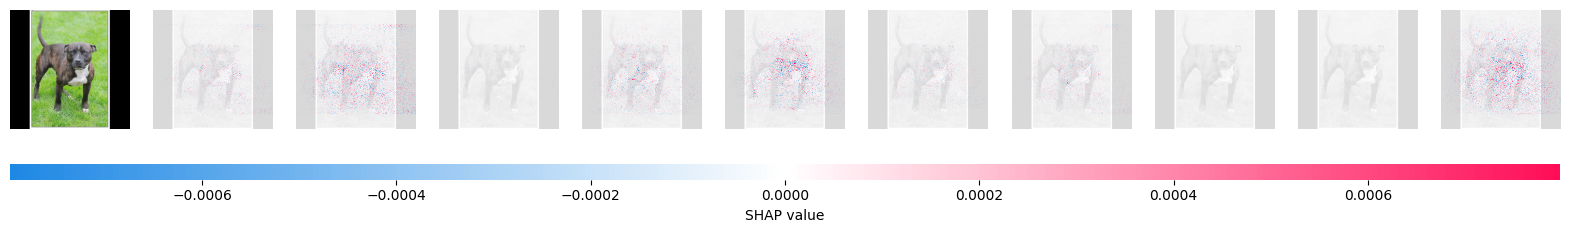

In [27]:
explainer = shap.GradientExplainer(model, X_train)
shap_values = explainer.shap_values(X_test[:5])

shap.image_plot([shap_values[i][0] for i in range(10)], X_train[5])
shap.image_plot([shap_values[i][0] for i in range(10)], X_test[1])
shap.image_plot([shap_values[i][0] for i in range(10)], X_test[3])

## MODEL 2 - VGG16

In [89]:
import tensorflow as tf

base_model = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))

for layers in base_model.layers:
   layers.trainable = False
x = tf.keras.layers.Flatten(name='flatten')(base_model.output)
x = tf.keras.layers.Dense(4096, activation='relu')(x)
x = tf.keras.layers.Dense(4096, activation='relu')(x)
x = tf.keras.layers.Dense(len(labelEncDict),  activation='softmax')(x) 

model = tf.keras.models.Model(inputs=base_model.input,outputs=x, name='VGG16')
opti_fun = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fun = 'categorical_crossentropy'
model.compile(optimizer=opti_fun, loss=loss_fun, metrics=['accuracy'])
# model.summary()
model.fit(train_data, epochs=200, validation_data=val_data)

NameError: name 'val_data' is not defined

In [ ]:
masker_blur = shap.maskers.Image("blur(128,128)", X_train[0].shape)
explainer_blur = shap.Explainer(f, masker_blur, output_names=list(labelDecDict.values()))
shap_values_fine = explainer_blur(X_train[0:2], max_evals=10000, batch_size=10, outputs=shap.Explanation.argsort.flip[:4])
shap.image_plot(shap_values_fine)

## MODEL 3: RESNET50

In [86]:
X_train_resized = tf.image.resize(X_train, (224, 224))
X_val_resized = tf.image.resize(X_val, (224, 224))
X_test_resized = tf.image.resize(X_test, (224, 224))
print(f'Training Data: {X_train_resized.shape}')
print(f'Validate Data: {X_val_resized.shape}')
print(f'Testing Data: {X_test_resized.shape}')

Training Data: (5984, 224, 224, 3)
Validate Data: (665, 224, 224, 3)
Testing Data: (739, 224, 224, 3)


In [87]:
datagen = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest')
train_data_resized = datagen.flow(x = X_train_resized, y = y_train, batch_size = BATCH_SIZE, shuffle = True)
val_data_resized = datagen.flow(x = X_val_resized, y = y_val, batch_size = BATCH_SIZE, shuffle = True)
test_data_resized = datagen.flow(x = X_test_resized, y = y_test, batch_size = BATCH_SIZE)

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# build the entire model
x = base_model.output
x = GlobalAveragePooling2D()(x) 
x = Dense(512, activation='relu')(x) 
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x) 
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x) 
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x) 
x = Dropout(0.5)(x)
predictions = Dense(len(labelEncDict), activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

# define training function
model.compile(optimizer=Adam(LEARNING_RATE), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(train_data_resized, validation_data=val_data_resized, epochs=200, batch_size=BATCH_SIZE)

# Save the model
model.save('Oxford-pet-'+base_model.name+'.hdf5')

In [70]:
# Convert TensorFlow tensors to NumPy arrays
X_train_resized = np.array(X_train_resized)
X_val_resized = np.array(X_val_resized)
X_test_resized = np.array(X_test_resized)

PartitionExplainer explainer: 3it [02:50, 85.43s/it]               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


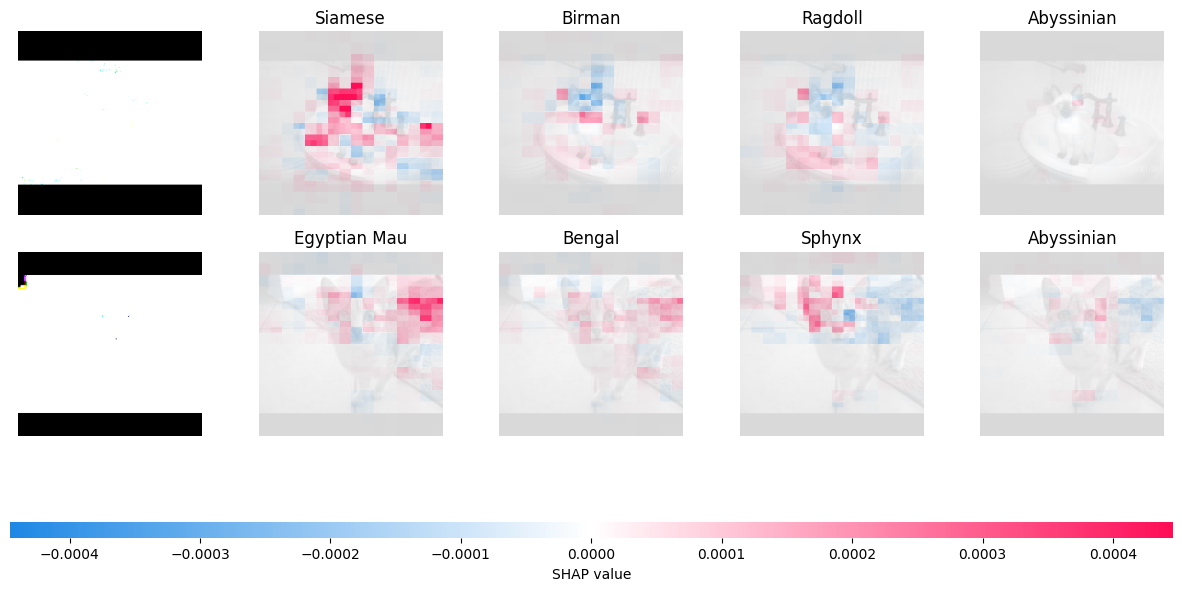

In [ ]:
masker = shap.maskers.Image("blur(128,128)", X_train_resized[0].shape)
explainer = shap.Explainer(f, masker, output_names=list(labelDecDict.values()))
shap_values_fine = explainer(X_train_resized[3:5], max_evals=10000, batch_size=10, outputs=shap.Explanation.argsort.flip[:4])
shap.image_plot(shap_values_fine)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


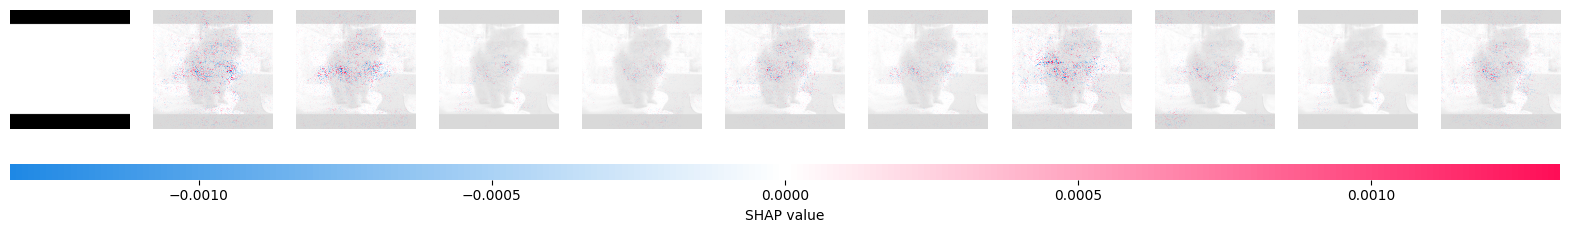

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


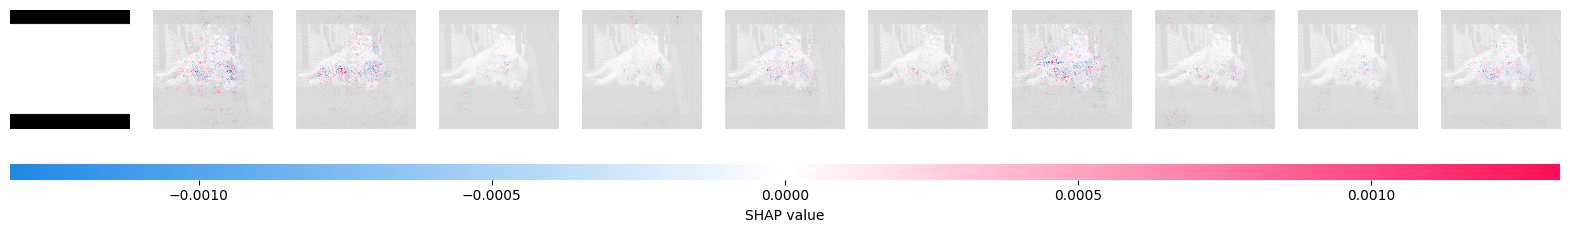

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


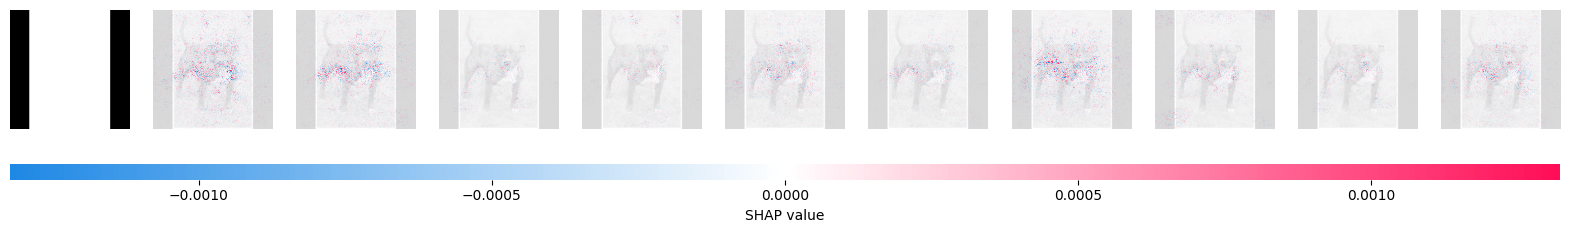

In [ ]:
explainer = shap.GradientExplainer(model, X_train_resized)
shap_values = explainer.shap_values(X_test_resized[:5])

shap.image_plot([shap_values[i][0] for i in range(10)], X_train_resized[5])
shap.image_plot([shap_values[i][0] for i in range(10)], X_test_resized[1])
shap.image_plot([shap_values[i][0] for i in range(10)], X_test_resized[3])

In [23]:
from PIL import Image

# Make predictions
def predict(image_path, target_size, model): 
  test_image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
  test_image = tf.keras.preprocessing.image.img_to_array(test_image)
  test_image = np.array([test_image]) 

  predictions = model.predict(test_image)
  predicted_class_index = np.argmax(predictions[0])
  predicted_class = labelDecDict[predicted_class_index]
  print("Predicted class:", predicted_class, " - index: ", predicted_class_index)

  image_test=Image.open(image_path)
  plt.title("This is a "+ predicted_class,fontsize=20)
  plt.imshow(image_test)
  plt.show()

1/1 [==============================] - 0s 158ms/step
Predicted class: yorkshire terrier  - index:  36


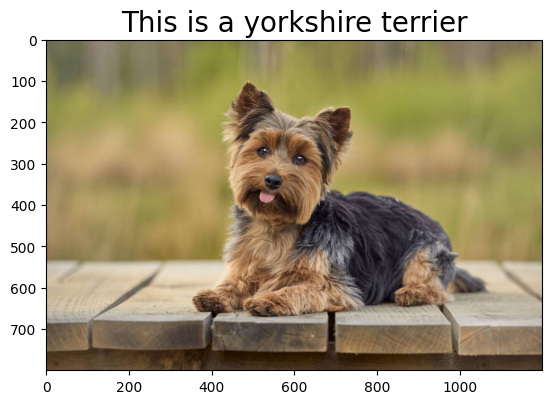

In [24]:
img_link = 'yorkshire-terrier-prendre.jpg'
target_size=(256,256)
model = tf.keras.models.load_model('Oxford-pet-CNN.hdf5')

# model = tf.keras.models.load_model('Oxford-pet-resnet50.hdf5')
# target_size=(224,224)

predict(img_link, target_size, model)

1/1 [==============================] - 0s 20ms/step
Predicted class: shiba inu  - index:  33


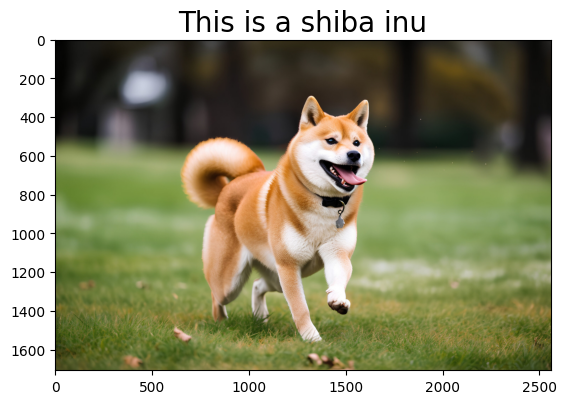

In [22]:
img_link = 'shiba-inu-dog-scaled.jpg'
predict(img_link, target_size, model)